In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch.nn as nn
from DNN import DeepNet
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device) # default tensor device
print("I'm using: ", device)

I'm using:  cpu
I'm using:  cpu


In [2]:
def convert(x):
  return x.cpu().detach().numpy()

def L2_diff(y,y_pred):
  return np.linalg.norm(y-y_pred,2)

## A simple ODE
We consider the problem
$$
\begin{cases}
    \displaystyle \frac{dy(t)}{dt} =  - 2y(t) =: f(t, y(t)) ,\ \ t\in (0,1)\\[15pt]
    y(0) = 1 =: y_0 .
\end{cases}
$$
That we want to approximate with a PINN. This means that we want to replace the solution $y(t)$ by a neural network $\Phi$, then optimize the parameters of the network to minimize the loss function
$$
\mathcal{L}(\Phi) := \sum_{i=1}^N \mathrm{dist}(\Phi'(t_i), f(t_i, \Phi(t_i))) + (\Phi(0)-y_0)^2,
$$
where $t_1, \dots, t_N$ are points in $(0,1)$ and for some distance $\mathrm{dist}$ that we will choose later.

Define a network `FNN`$:\mathbb{R}\to\mathbb{R}$ with 3 layers, 5 neurons and `tanh` (see https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#tanh) as the activation function. Use the `DeepNet` class from the first lab, provided in the `DNN` module that we have imported.

In [3]:
input = 1
output = 1
hidden_layer = 3*[5]
activation_function = nn.Tanh()

FNN = DeepNet(activation_function, input, hidden_layer, output)
FNN

DeepNet(
  (activation): Tanh()
  (hidden): ModuleList(
    (0): Linear(in_features=1, out_features=5, bias=True)
    (1-2): 2 x Linear(in_features=5, out_features=5, bias=True)
  )
  (output): Linear(in_features=5, out_features=1, bias=False)
)

Using `torch.rand`, define the points that will be used for training (i.e., where the residuals will be computed). For the points used for testing, use `torch.linspace`. We use $50$ points for training, and test on $100$ points.


In [4]:
t0 = torch.Tensor([0]).to(device)
y0 = torch.Tensor([1]).to(device)  

n_train_points = 50
n_test_points  = 100

t_train = torch.rand([n_train_points, 1]) # we want a (n_train_points x 1) vector here
t_sort_train,_ = torch.sort(t_train,0) 
t_test  = torch.linspace(0,1,n_test_points).unsqueeze(1) # n_test_points x 1

Visualize the points

Text(0.5, 1.0, 'Collocation Points')

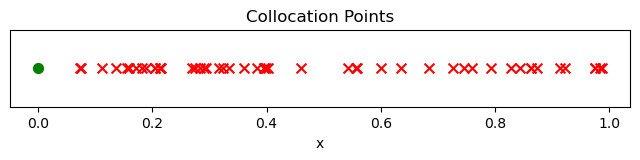

In [5]:
plt.figure(figsize=(8, 1),num =1)  
plt.scatter(convert(t_train), np.zeros_like(convert(t_train)), color='red', s=50, marker='x', label='Collocation Points')
plt.scatter(convert(t0), np.zeros_like(convert(t0)), color='green', s=50, label='Collocation Points')
plt.xlabel('x')
plt.yticks([])  
plt.title('Collocation Points')


We define the exact solution and the right hand side function $f(t, y)$

In [6]:
def exact_sol(t):
    ## takes a torch vector as input, returs a numpy vector
    return np.exp(-2*convert(t))

def rhs(t, y):
    return -2*y

Definition of the loss function for the training, where the metric will be defined later. Some examples can be https://pytorch.org/docs/stable/nn.html#loss-functions.

Let $\Phi$ be the neural network approximating $y$. The first function takes $\Phi$, a vector of points $\mathbf{t} = (t_i)_i$, the right hand side function $f:\mathbb{R}\times\mathbb{R}\to\mathbb{R}$, and finally a function `metric`$:\mathbb{R}^N\times \mathbb{R}^N\to \mathbb{R}_+$ which computes some distance between the vectors.

The function then computes $\Phi(\mathbf{t})$ and $\Phi'(\mathbf{t})$ and finally it returns 
$$
\mathtt{metric}(\Phi'(\mathbf{t}), f(\mathbf{t}, \Phi(\mathbf{t})))
$$

The second function computes the (squared) error in the inital condition, i.e., $(\Phi(0) - y_0)^2$

In [ ]:
def eval_loss_ode(NN, t, f, metric):
    t.requires_grad_(True)
    y_NN = NN(t)
    y_NN_t = torch.autograd.grad(y_NN.sum(), t, create_graph =True)[0] 
    return metric(y_NN_t, f(t, y_NN))


def eval_loss_IC(NN_0, y_0):
    return (NN_0 - y_0).pow(2).squeeze()

Training of the network: see https://pytorch.org/docs/stable/optim.html for an overview. We start by defining the total number of iteration steps, and initialize the Adam optimizer and learning rate scheduler. Finally, we choose the distance function to compute the residuals.



In [8]:
n_epochs = 2000
learning_rate = 1e-3
optimizer = torch.optim.Adam(FNN.parameters(), learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 50, 0.98)
loss_values = np.empty([n_epochs+1, 3]); #total,ode, 0

MSE =  torch.nn.MSELoss()

We then set the variables for saving the results and initialize the values of the exact solution on the training and test point sets.

In [9]:
STEP = 200  # save every STEP epochs
assert n_epochs%STEP == 0

err = np.empty([int(n_epochs/STEP)+1, 2])
y_animate =  np.empty([int(n_epochs/STEP)+1, n_train_points])
err_animate = np.empty([int(n_epochs/STEP)+1, n_train_points])
k = 0 

y_exact_train = exact_sol(t_train)
y_exact_test  = exact_sol(t_test)
y_exact_train_sort = exact_sol(t_sort_train)


We now start iterating on the optimization procedure

In [10]:
for epoch in range(n_epochs+1):
    
    # t_train.requires_grad_(True)
    # y_NN = FNN(t_train)
    # y_NN_t = torch.autograd.grad(y_NN.sum(),t_train,create_graph =True)[0] 

    loss_ode = eval_loss_ode(FNN, t_train, rhs, MSE)
    
    y_NN_0 = FNN(t0)
    loss_IC = eval_loss_IC(y_NN_0,y0)

    loss = loss_ode + loss_IC
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    loss_values[epoch,:] = np.stack([convert(loss),convert(loss_ode),convert(loss_IC)])

    if epoch%STEP == 0:
        lr = np.array(scheduler.get_last_lr())
        y_NN_test =  FNN(t_test)
        err[k,:]  = [L2_diff(convert(FNN(t_train)),y_exact_train), L2_diff(convert(y_NN_test), y_exact_test)]
        y_animate[k,:]  = convert(FNN(t_sort_train).squeeze())
        err_animate[k,:]= (np.abs(y_animate[k,:] - y_exact_train_sort.squeeze()))
        print(f'Epoch {epoch} || learning rate {lr.squeeze():.2e}  || Error  Train {err[k,0]:.2e} || Error Test  {err[k,1]:.2e}''\n'
              f'Global loss {loss_values[epoch,0]:.2e} || loss ode {loss_values[epoch,1]:.2e} || loss IC {loss_values[epoch,2]:.2e}','\n')
        k+=1


Epoch 0 || learning rate 1.00e-03  || Error  Train 5.58e+00 || Error Test  7.87e+00
Global loss 2.14e+00 || loss ode 3.59e-01 || loss IC 1.78e+00 

Epoch 200 || learning rate 9.22e-04  || Error  Train 2.20e+00 || Error Test  3.20e+00
Global loss 6.75e-01 || loss ode 1.01e-01 || loss IC 5.73e-01 

Epoch 400 || learning rate 8.51e-04  || Error  Train 6.01e-01 || Error Test  9.74e-01
Global loss 9.49e-02 || loss ode 2.90e-02 || loss IC 6.59e-02 

Epoch 600 || learning rate 7.85e-04  || Error  Train 6.85e-02 || Error Test  1.56e-01
Global loss 1.46e-02 || loss ode 1.10e-02 || loss IC 3.57e-03 

Epoch 800 || learning rate 7.24e-04  || Error  Train 4.23e-02 || Error Test  5.96e-02
Global loss 3.69e-03 || loss ode 3.11e-03 || loss IC 5.73e-04 

Epoch 1000 || learning rate 6.68e-04  || Error  Train 5.60e-02 || Error Test  7.58e-02
Global loss 1.68e-03 || loss ode 1.57e-03 || loss IC 1.12e-04 

Epoch 1200 || learning rate 6.16e-04  || Error  Train 5.40e-02 || Error Test  7.44e-02
Global loss 1.

# Visualization of the results
Value of the loss function throughout the optimization process

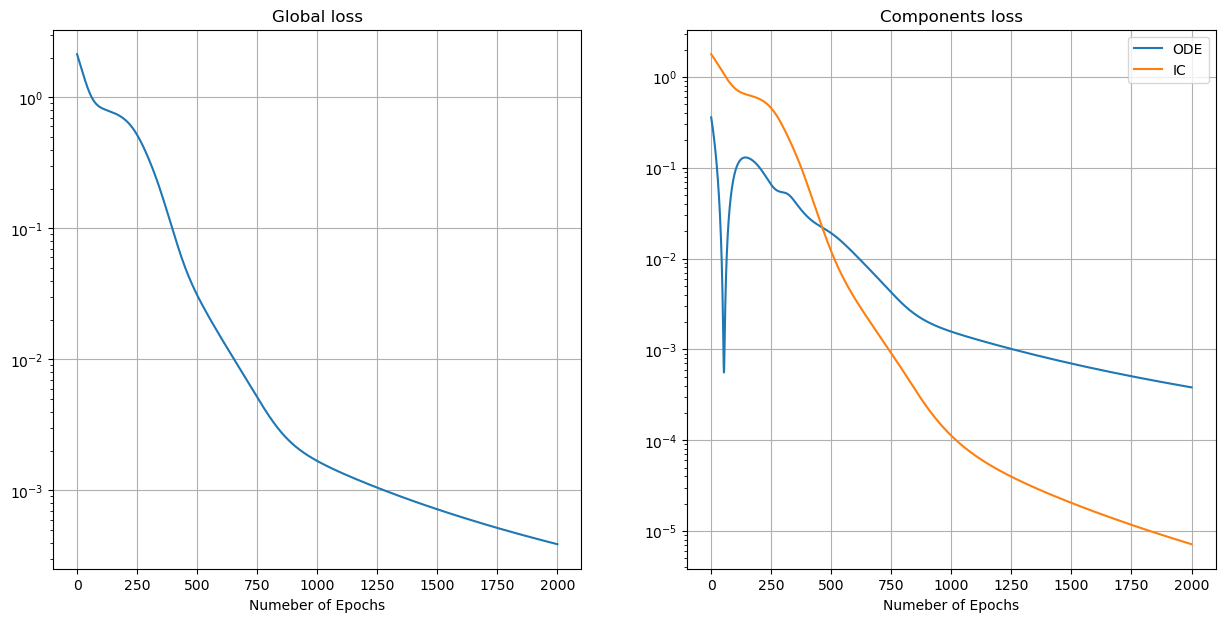

In [11]:
epochs = range(n_epochs+1)
#y_lims = [np.min(loss_values)*0.8,np.max(loss_values)*1.2]

fig, axs = plt.subplots(1,2,figsize = (15,7), num =4)
axs[0].semilogy(epochs,loss_values[:,0])
axs[0].set_xlabel('Numeber of Epochs')
#axs[0].set_ylim(y_lims)
axs[0].grid('on')
axs[0].set_title('Global loss')

axs[1].semilogy(epochs,loss_values[:,1],label = 'ODE')
axs[1].semilogy(epochs,loss_values[:,2],label = 'IC' )
axs[1].set_xlabel('Numeber of Epochs')
#axs[1].set_ylim(y_lims)
axs[1].legend()
axs[1].grid('on')
axs[1].set_title('Components loss')

plt.show()

Compare the exact solution with the PINN prediction and evaluate the pointwise error

In [12]:
t_test = convert(t_test)
y_NN_test = convert(y_NN_test)
t_sort_train = convert(t_sort_train)

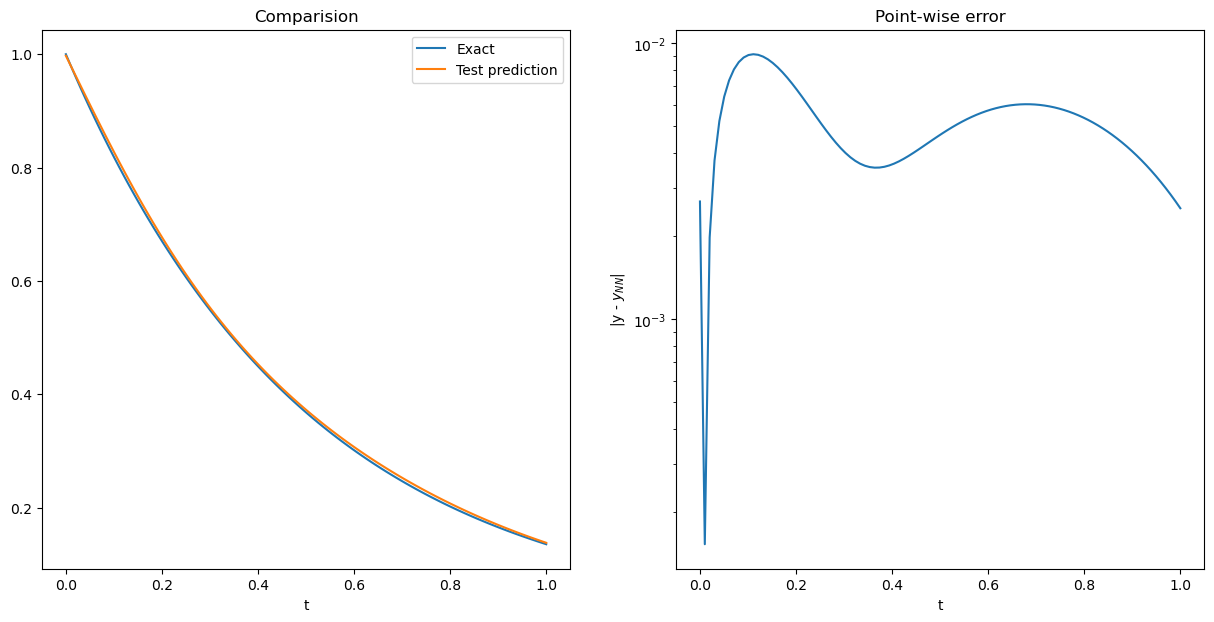

In [13]:
fig, axs = plt.subplots(1,2,figsize = (15,7))
axs[0].plot(t_test,y_exact_test,label = 'Exact')
axs[0].plot(t_test,y_NN_test, label = 'Test prediction')
axs[0].set_xlabel('t')
axs[0].legend()
axs[0].set_title('Comparision')

axs[1].semilogy(t_test,np.abs(y_exact_test-y_NN_test))
axs[1].set_title('Point-wise error')
axs[1].set_xlabel('t')
axs[1].set_ylabel('|y - $y_{NN}$|')
plt.show()

$L^2$ Errors

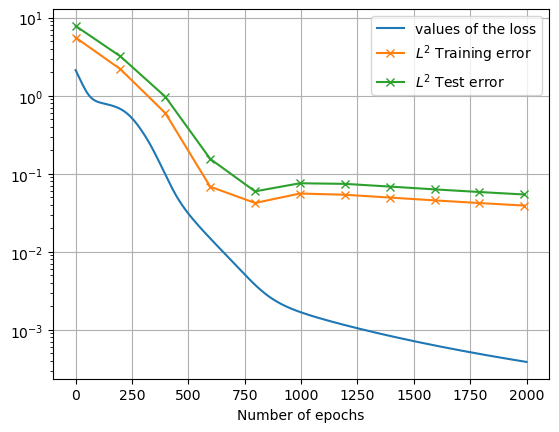

In [14]:

epochs = range(n_epochs+1)
y_lims = [np.min(loss_values)*0.8,np.max(loss_values)*1.2]
plt.figure(4)
plt.semilogy(epochs,loss_values[:,0],label = 'values of the loss')
plt.semilogy(epochs[0:-1:STEP-1],err[:,0],'-x', label = '$L^2$ Training error')
plt.semilogy(epochs[0:-1:STEP-1],err[:,1],'-x', label = '$L^2$ Test error')

plt.xlabel('Number of epochs')
plt.grid('on')
plt.legend()
plt.show()

Animation of the solution and of the pointwise error during training

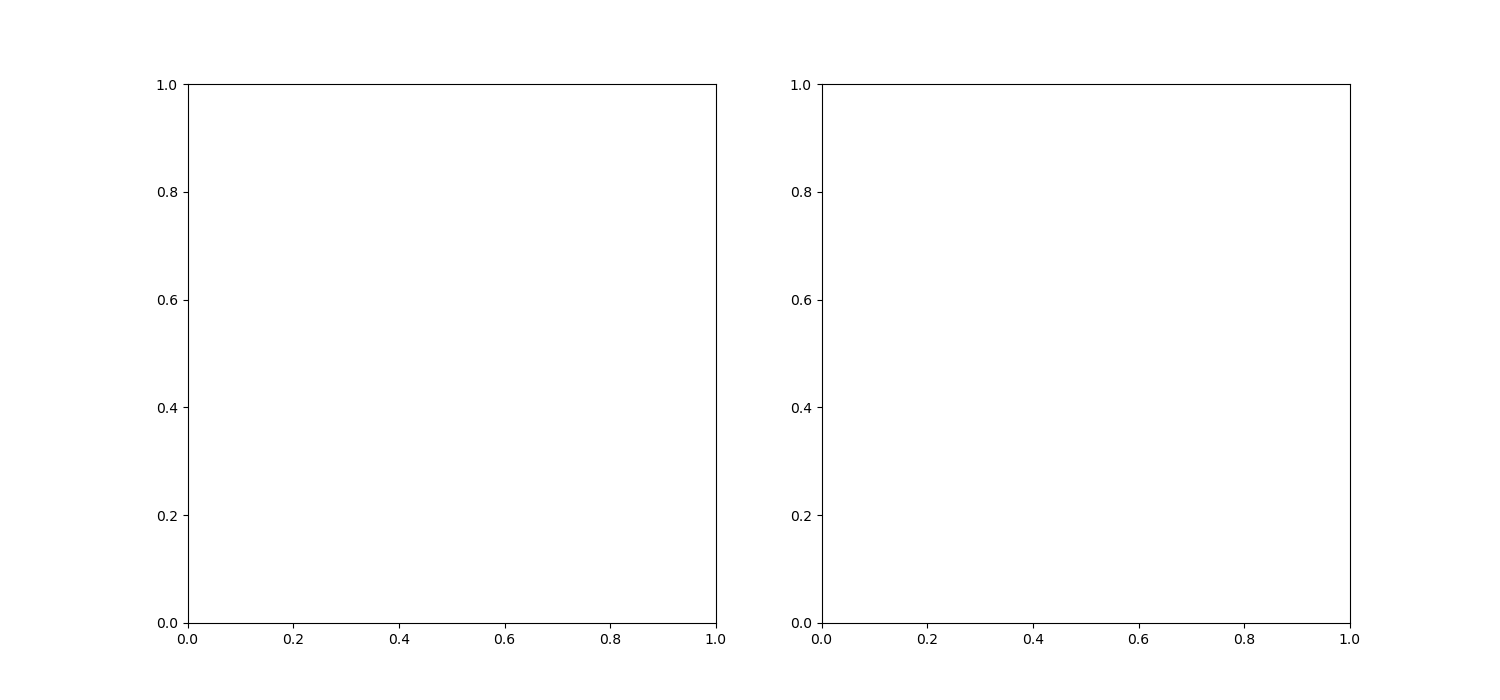

In [15]:
%matplotlib widget
fig, axs = plt.subplots(1,2, figsize = (15,7),num = 3)

def updata_data(frame):
    axs[0].clear()
    axs[0].plot(t_sort_train,y_animate[frame,:],'b--',label = r'$y_{\Theta}$')
    axs[0].plot(t_sort_train,y_exact_train_sort,'r', label = 'Exact')
    axs[0].set_ylim([0,1.1])
    axs[0].set_xlim([0,1])
    axs[0].set_xlabel('t')

    axs[0].grid('on')
    axs[0].legend()

    axs[1].clear()
    axs[1].semilogy(t_sort_train,err_animate[frame,:])
    axs[1].grid('on')
    axs[1].set_ylim([np.min(err_animate)*0.9,np.max(err_animate)*1.1])
    axs[1].set_xlabel('t')
    axs[1].set_title(r'$|y - y_{\Theta}|$')
    plt.suptitle(f'Epoch {frame*STEP} || error {err[frame,0]:.2e}')
    return axs[0]

animation = FuncAnimation(fig,func = updata_data,frames=len(y_animate),interval = 500,)
plt.show()
#for google colab
#from IPython.display import HTML
#video = HTML(anim.to_html5_video())
#display(video)
#plt.close()